Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a href = "MPP Plotting.ipynb">MPP Plotting</a>
        </li>
        <li class = "">
            <a href = "MPP Decision Tree.ipynb">MPP Decision Tree</a>
        </li>
        <li class = "">
            <a>MPP ROC Curve</a>
        </li>
        

 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20ROC%20Curve.ipynb#Import-useful-libraries" data-toc-modified-id="Import-useful-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import useful libraries</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20ROC%20Curve.ipynb#Connect-to-Database" data-toc-modified-id="Connect-to-Database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Connect to Database</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20ROC%20Curve.ipynb#Autofill-Table-Names" data-toc-modified-id="Autofill-Table-Names-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Autofill Table Names</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20ROC%20Curve.ipynb#Define-magic-functions---helpful-for-interacting-with-cluster" data-toc-modified-id="Define-magic-functions---helpful-for-interacting-with-cluster-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define magic functions - helpful for interacting with cluster</a></span></li><li><span><a href="http://localhost:8888/notebooks/mpp-plotting/MPP%20ROC%20Curve.ipynb#Create-Fake-Data" data-toc-modified-id="Create-Fake-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create Fake Data</a></span></li></ul></div>

# Import useful libraries

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import getopt
import os
import sys
import urllib

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic,\
                               register_line_magic
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns

# Credentials file to connect to database
import credentials
from mpp_plotting import *

In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set Seaborn Colours
sns.set_palette('colorblind')
sns.set_style('darkgrid')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

# Connect to Database

In [4]:
conn = psycopg2.connect(**credentials.login_info_dict)
conn.autocommit = True

schema_name = 'template'
psql.execute('SET search_path TO {}'.format(schema_name), conn)

<cursor object at 0x113478a50; closed: 0>

# Autofill Table Names
One downside of interacting with a remote database in Python is that table names will not be imported in. When this is run, it will import all of the schema names as classes and their respective table names as variables. That way, when we type a schema name, we can use tab completion to list out all of its columns.

In [5]:
class Schema:
    def __init__(self, tables):
        for t in tables:
            exec('self.{t} = "{t}"'.format(t=t))

def refresh_tables(conn):
    """Refreshes the auto-fill tables."""
    sql = '''
    SELECT table_schema, array_agg(table_name::TEXT) AS tables
      FROM information_schema.tables
     GROUP BY table_schema;
    '''
    info_df = psql.read_sql(sql, conn)

    for row in info_df.iterrows():
        command = '''
        global {s}
        {s} = Schema({tables})
        '''.format(s=row[1][0], tables=row[1][1])
        exec(dedent(command))

# Define magic functions - helpful for interacting with cluster

In [6]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df. This also takes in an option "-h", followed 
    by a number. This will show only the specified number of rows
    in the DataFrame.
    """
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist) 
    # If '-h' tag is specified, set the number of rows to display
    if '-h' in optdict:
        head_num = int(optdict['-h'])
     
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals()) 
    
    # If there is more than one table name specified,
    # throw an exception.
    if len(args) > 1:
        raise Exception('More than one table name specified')

    elif len(args) == 1:
        # If a table name is specified, store it as that
        table_name = args[0]
        globals()[table_name] = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(globals()[table_name].head(int(optdict['-h'])))
        else:
            display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell, conn)
        if '-h' in optdict:
            # If head_num is not 0, then display rows
            if head_num != 0:
                display(_df.head(head_num))
        else:
            display(_df)

@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    # Use the global connection object defined above.
    global conn
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)

    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    psql.execute(cell, conn)

@register_cell_magic
def printsql(line, cell):
    """
    Show the SQL query that will be run.
    """
    optlist, args = getopt.getopt(line.split(), 'ih:')
    optdict = dict(optlist)
    
    split_cell = cell.split('$')
    if '-i' not in optdict:
        if len(split_cell) > 1:
            split_cell[0] = split_cell[0].format(**globals())
            split_cell[-1] = split_cell[-1].format(**globals())
            cell = '$'.join(split_cell)
        elif len(split_cell) == 1:
            cell = cell.format(**globals())
    print cell

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql, printsql

# Create Fake Data

In [7]:
%%execsql
DROP TABLE IF EXISTS roc_data;
CREATE TABLE roc_data
   AS SELECT random()::INT AS y_true,
             random() AS y_score
        FROM generate_series(1, 2000);

In [8]:
%%readsql -h 5 df
SELECT *
  FROM roc_data
 ORDER BY y_score;

,y_true,y_score
0,0,0.000142
1,1,0.000286
2,1,0.000787
3,0,0.001300
4,1,0.002896


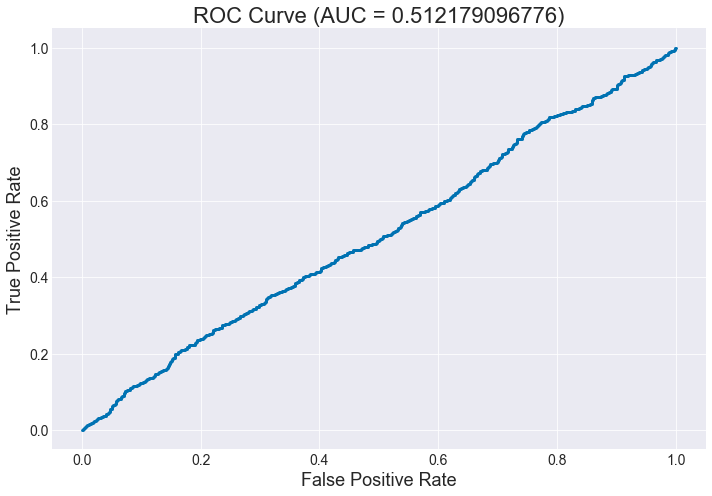

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresh = roc_curve(df.y_true, df.y_score)
auc_score = roc_auc_score(df.y_true, df.y_score)
plt.plot(fpr, tpr)
plt.title('ROC Curve (AUC = {})'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()

We compare this to the ROC curve computed in database.

In [10]:
roc_df = get_roc_values('roc_data', 'y_true', 'y_score', conn)
# Compute the AUC in database
db_auc_score = get_roc_auc_score(roc_df)

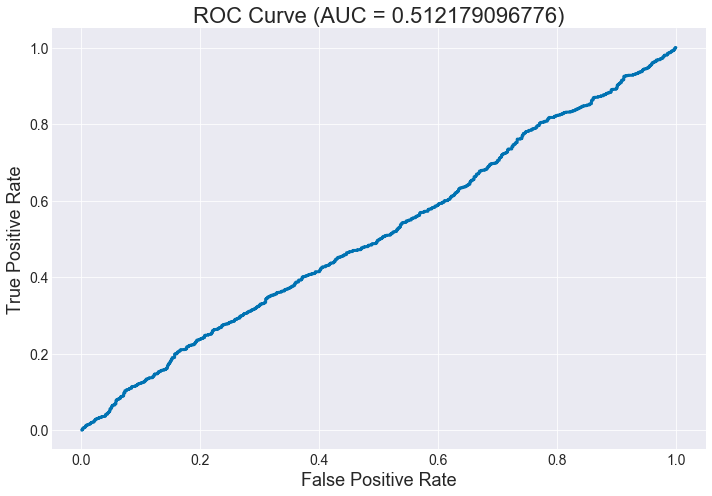

In [11]:
plt.plot(roc_df.fpr, roc_df.tpr)
plt.title('ROC Curve (AUC = {})'.format(db_auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()